# Lab 12

En este laboratorio cubrimos transformers utilizando texto en el contexto de clasificación con la arquitectura BERT

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Librerías
import keras
from keras import ops
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
from datasets import load_dataset
from transformers import AutoTokenizer
import pandas as pd


In [3]:
# Parameters
max_length = 128  # Maximum length of the input tokens
#num_classes = 2   # Number of output classes (binary classification here)
vocab_size = 20000  # Only consider the top 20k
batch_size = 8
metric_name = "f1"

# Datos y preparación

Este conjunto de datos es parte de la Tarea 1 de SemEval 2018, que contiene varias subtareas. La subtarea 5 (en inglés) se centra en clasificar los tuits en diferentes categorías de emociones (anger, fear, etc)

In [12]:
# Load data
dataset = load_dataset("sem_eval_2018_task_1", "subtask5.english")
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]

# Muestra
num_samples = 500
train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
val_ds = dataset["validation"].shuffle(seed=42).select(range(num_samples))
test_ds = dataset["test"].shuffle(seed=42).select(range(num_samples))


In [5]:
train_ds

Dataset({
    features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 500
})

In [6]:
train_ds[0]


{'ID': '2017-En-31577',
 'Tweet': 'Try to find the good in the negative. The negative can turn out to be good.\\n #anxietyrelief  #openminded',
 'anger': False,
 'anticipation': False,
 'disgust': False,
 'fear': False,
 'joy': False,
 'love': False,
 'optimism': True,
 'pessimism': False,
 'sadness': False,
 'surprise': False,
 'trust': False}

In [7]:
# Etiquetas - emociones/clases
labels = [label for label in dataset['train'].features.keys() if label not in ['ID', 'Tweet']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

# Preparación de los datos

In [13]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["Tweet"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=max_length)

  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels} # diccionario
  print(labels_batch)
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  print(labels_matrix)
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]


  encoding["labels"] = labels_matrix.tolist()





  return encoding

# Aplicar preprocesamiento
train_ds = train_ds.map(preprocess_data, batched=True, remove_columns=train_ds.column_names)
val_ds = val_ds.map(preprocess_data, batched=True, remove_columns=val_ds.column_names)
test_ds = test_ds.map(preprocess_data, batched=True, remove_columns=test_ds.column_names)

train_ds

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'anger': [False, True, True, False, True, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, True, True, True, True, False, False, False, False, True, True, True, False, False, True, True, False, False, False, False, False, False, True, True, True, False, False, True, False, False, True, False, False, False, False, True, True, True, False, False, False, True, False, False, False, True, True, False, False, False, True, False, True, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, True, False, False, True, True, False, False, False, False, False, False, True, False, True, True, True, False, False, True, False, False, True, False, False, False, True, False, False, True, False, True, False, True, True, False, False, True, False, True, False, False, True, False, False, False, False, True, True, False, False, False, True, False

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'anger': [True, True, False, False, True, False, False, False, True, True, False, True, False, False, False, False, False, True, False, True, False, True, True, True, True, False, True, False, False, False, False, False, False, True, False, True, False, True, False, True, False, False, False, False, False, True, False, False, False, False, False, True, True, False, False, False, True, True, False, False, False, False, False, True, False, True, False, False, True, False, True, False, False, False, False, False, True, False, False, False, True, True, False, True, True, False, False, True, False, True, False, False, False, True, True, False, True, True, False, True, False, True, True, False, True, False, False, True, True, False, True, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, Tr

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'anger': [False, False, True, False, False, True, False, False, False, False, True, False, True, True, False, False, True, False, False, False, True, True, True, False, False, False, False, False, False, True, True, False, True, True, False, True, False, False, True, False, True, True, False, False, False, False, True, True, False, True, False, False, False, True, True, False, True, True, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, True, True, False, True, False, False, False, False, True, False, False, False, False, False, False, False, True, True, False, False, True, False, False, False, True, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, True, False, False, False, Fa

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 500
})

In [ ]:
train_ds.set_format("tf")
val_ds.set_format("tf")
test_ds.set_format("tf")

# Arquitectura

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    report_to="none"
    #push_to_hub=True,
)



# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Entrenamiento

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
hist = trainer.train()

<ipython-input-23-7133f68b8793>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.481885,0.000000,0.500000,0.014000
2,No log,0.464251,0.047733,0.511477,0.016000
3,No log,0.401516,0.528139,0.683645,0.170000
4,No log,0.378023,0.588813,0.720434,0.194000
5,No log,0.366586,0.586802,0.716792,0.188000
6,No log,0.365864,0.616042,0.738180,0.182000
7,No log,0.360249,0.602685,0.726749,0.190000
8,0.370000,0.362227,0.591897,0.721543,0.172000
9,0.370000,0.359526,0.604514,0.728861,0.176000
10,0.370000,0.360124,0.597352,0.725057,0.174000


Index(['eval_loss', 'eval_f1', 'eval_roc_auc', 'eval_accuracy', 'eval_runtime',
       'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'],
      dtype='object')


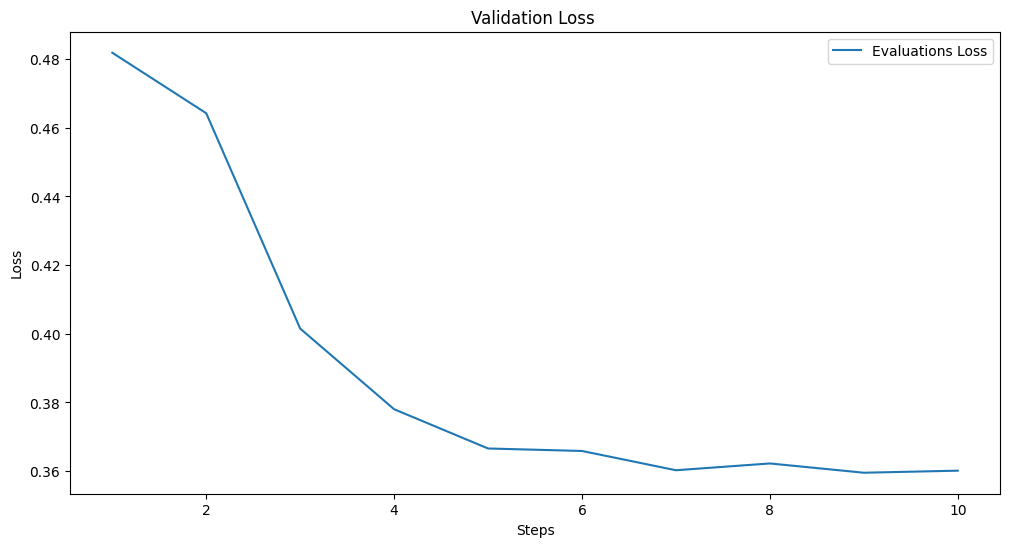

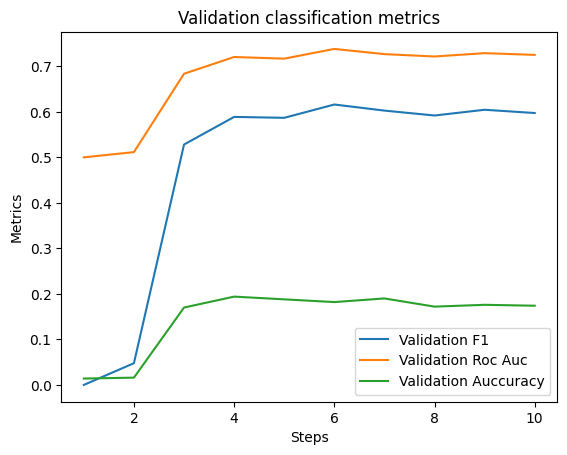

In [ ]:
# Gráficos
# Convert log history to a DataFrame for easier plotting
log_history = pd.DataFrame(trainer.state.log_history)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(log_history)

# Separate evaluation and training rows
eval_df = df[~df['eval_loss'].isnull()]
eval_df = eval_df[eval_df.columns[eval_df.columns.str.startswith('eval_') | eval_df.columns.isin(['epoch', 'step'])]]

print(eval_df.columns)
# Plot training loss and evaluation loss over epochs
plt.figure(figsize=(12, 6))

# Plot Evaluation Loss
plt.plot(eval_df['epoch'],
         eval_df['eval_loss'],
         label='Evaluations Loss')

# Add labels and legend
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss ')
plt.show()

# Plot Evaluation Accuracy
plt.plot(eval_df['epoch'],
          eval_df['eval_f1'],
          label='Validation F1')
plt.plot(eval_df['epoch'],
          eval_df['eval_roc_auc'],
          label='Validation Roc Auc')
plt.plot(eval_df['epoch'],
          eval_df['eval_accuracy'],
          label='Validation Auccuracy')

# Add labels and legend
plt.xlabel('Steps')
plt.ylabel('Metrics')
plt.legend()
plt.title('Validation classification metrics')
plt.show()

# Evaluación

In [ ]:
trainer.evaluate()

{'eval_loss': 0.3658643066883087,
 'eval_f1': 0.6160417655434267,
 'eval_roc_auc': 0.73817986823962,
 'eval_accuracy': 0.182,
 'eval_runtime': 3.9171,
 'eval_samples_per_second': 127.645,
 'eval_steps_per_second': 16.083,
 'epoch': 10.0}

In [ ]:
trainer.evaluate(eval_dataset=test_ds)

{'eval_loss': 0.35838449001312256,
 'eval_f1': 0.6129188926663429,
 'eval_roc_auc': 0.7348166395359447,
 'eval_accuracy': 0.21,
 'eval_runtime': 5.2733,
 'eval_samples_per_second': 94.817,
 'eval_steps_per_second': 11.947,
 'epoch': 10.0}